<a href="https://colab.research.google.com/github/bysischpok/Lab1/blob/main/%D0%9B%D0%B0%D0%B12_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB
   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  

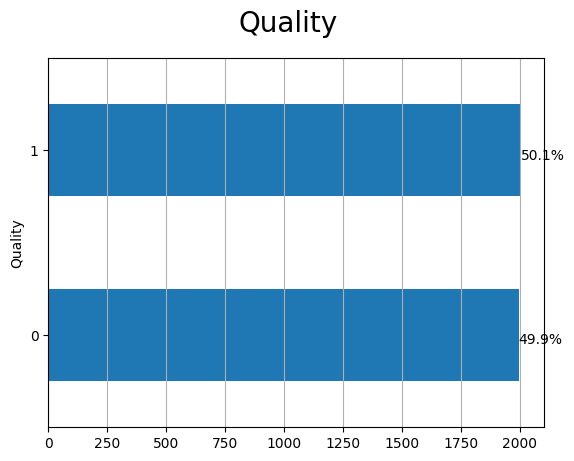

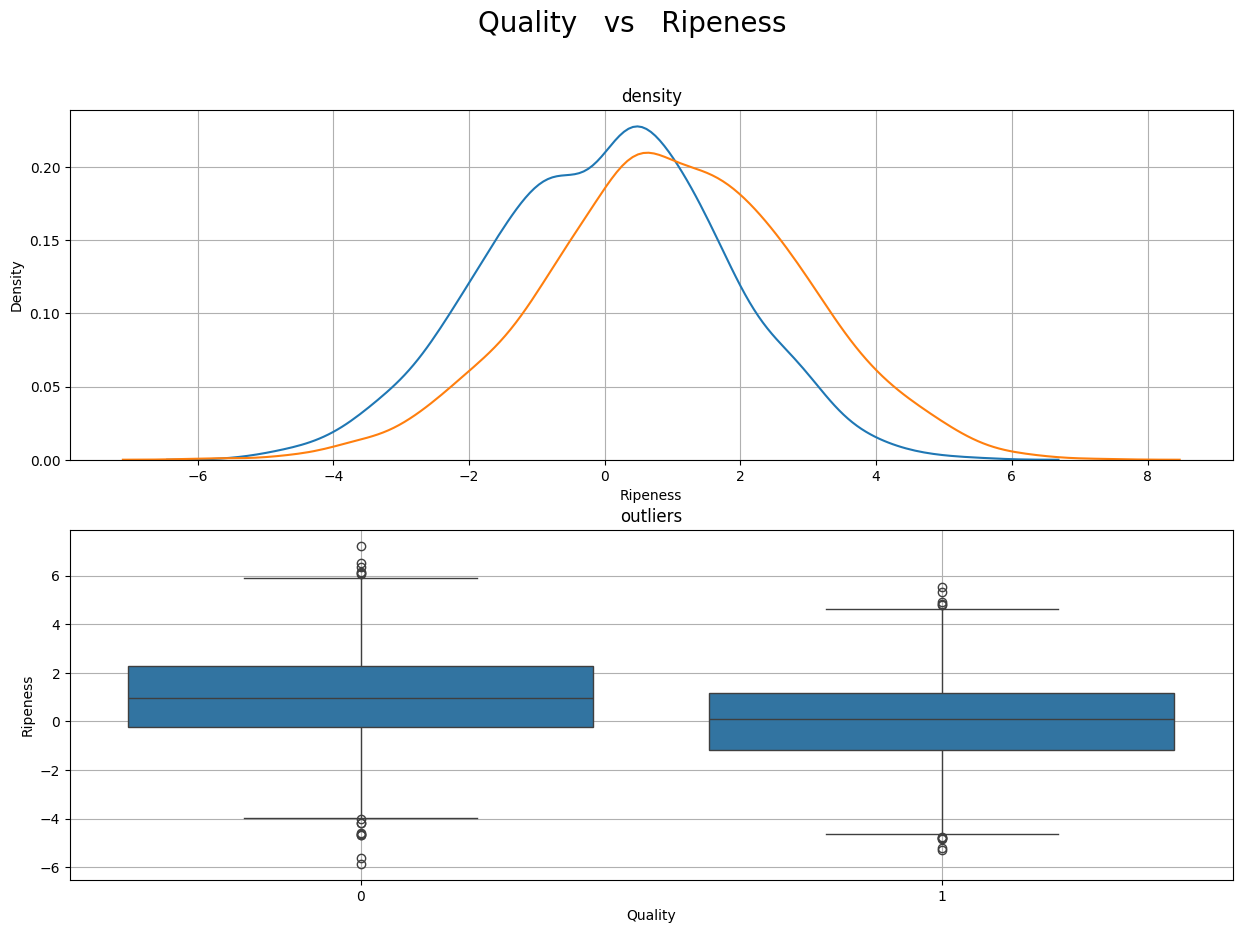

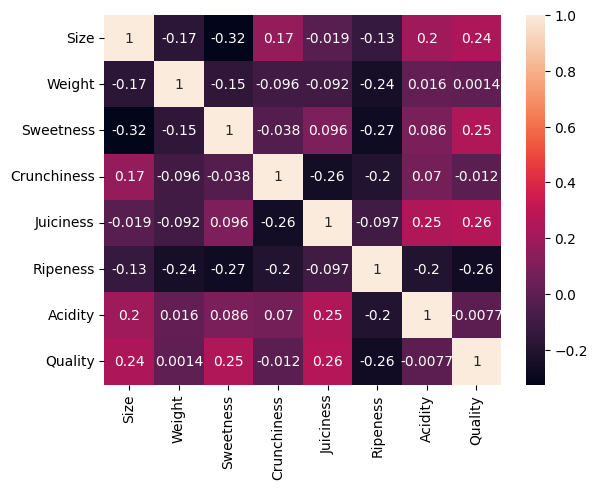

Best Model parameters: {'subsample': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 5, 'learning_rate': 0.05}
Best Model mean accuracy: 0.8782142857142858


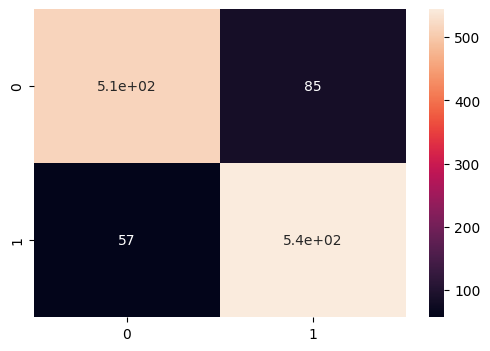

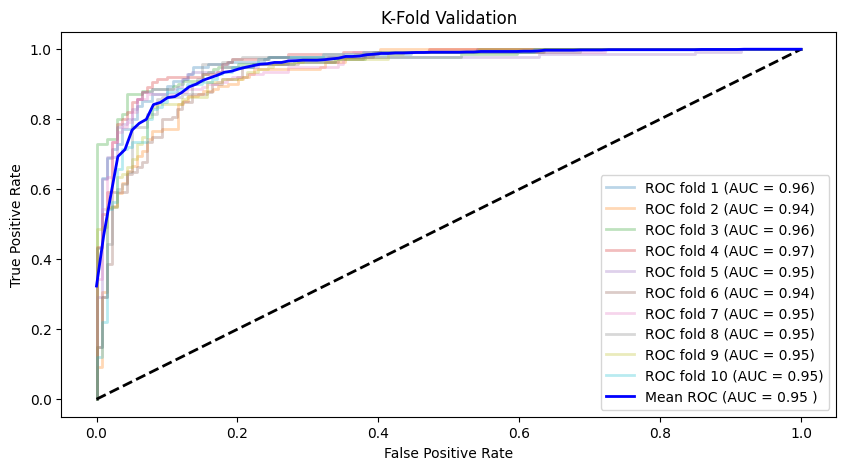

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#_________Чтение датасета, замена категориального столбца на числовой___________
data = pd.read_csv('apple_quality.csv')
data.info()
print(data.head())
data['Quality'].value_counts()
data = data.dropna()
data = data.drop(['A_id'], axis=1)
replace_dict = {'good': 1, 'bad': 0}
data['Quality'] = data['Quality'].map(replace_dict)
#_____________________Сравнение количства good и bad в целевом столбце__________
y ="Quality"
ax = data[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()
#______________________Оценка важности признака Ripeness________________________
cat, num = "Quality", "Ripeness"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))# распаковываем  кортеж в переменные figи ax.
fig.suptitle(cat+"   vs   "+num, fontsize=20)# получаем объект рисунка и массив подграфиков,где первое число - количество строк,второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
ax[0].title.set_text('density')
for i in data[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(data[data[cat]==i][num],   label=i, ax=ax[0])#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=data, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.
ax[1].grid(True)#Настроим линии сетки.
plt.show()
#___________Разбиение на тестовую и тренировочную части, нормирование___________
X = data.drop(['Quality'], axis=1)
y = data['Quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15, stratify=y)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X_train)

sns.heatmap(data.corr(), annot=True)
plt.show()
#___________________Подбор параметров и обучение модели_________________________
model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне
model.fit(X_train, y_train)
predicted = model.predict(X_test).astype('int32')
model_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(6, 4))
sns.heatmap(model_matrix, annot=True)
plt.show()
#____________________ROC-кривые_________________________________________________
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):


    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()